## Changes:

Removed where the data is sourced is gathered from ##uploaded = files.upload(), where in colab you upload your data,


Please upload your Excel file now.
The file should contain the following columns:
'product name', 'quantity liters', 'process speed per hour', 'line efficiency', 'Change Over', 'Date from', 'Duration', 'Gap'
--------------------------------------------------


Saving Final example_production_data.xlsx to Final example_production_data (10).xlsx
File 'Final example_production_data (10).xlsx' uploaded successfully.

Data loaded:
     product name  quantity liters  process speed per hour  \
0  AO Almond UNSW            83232                   15000   
1    Aldi IG UNSW            90000                   15000   
2   ML Almond Int           180000                   15000   
3   ML Almond 8x1           363552                   15000   
4  ML Almoind 8x1           181776                   15000   

            Date from  line efficiency  Change Over   Gap  Duration  
0 2025-09-08 09:30:00             0.50            0  1440       330  
1                 NaT             0.65           50     0       330  
2                 NaT             0.80           40     0       330  
3                 NaT             0.80           40     0       330  
4                 NaT             0.80           40     0       330  

An error occurred during processing: 

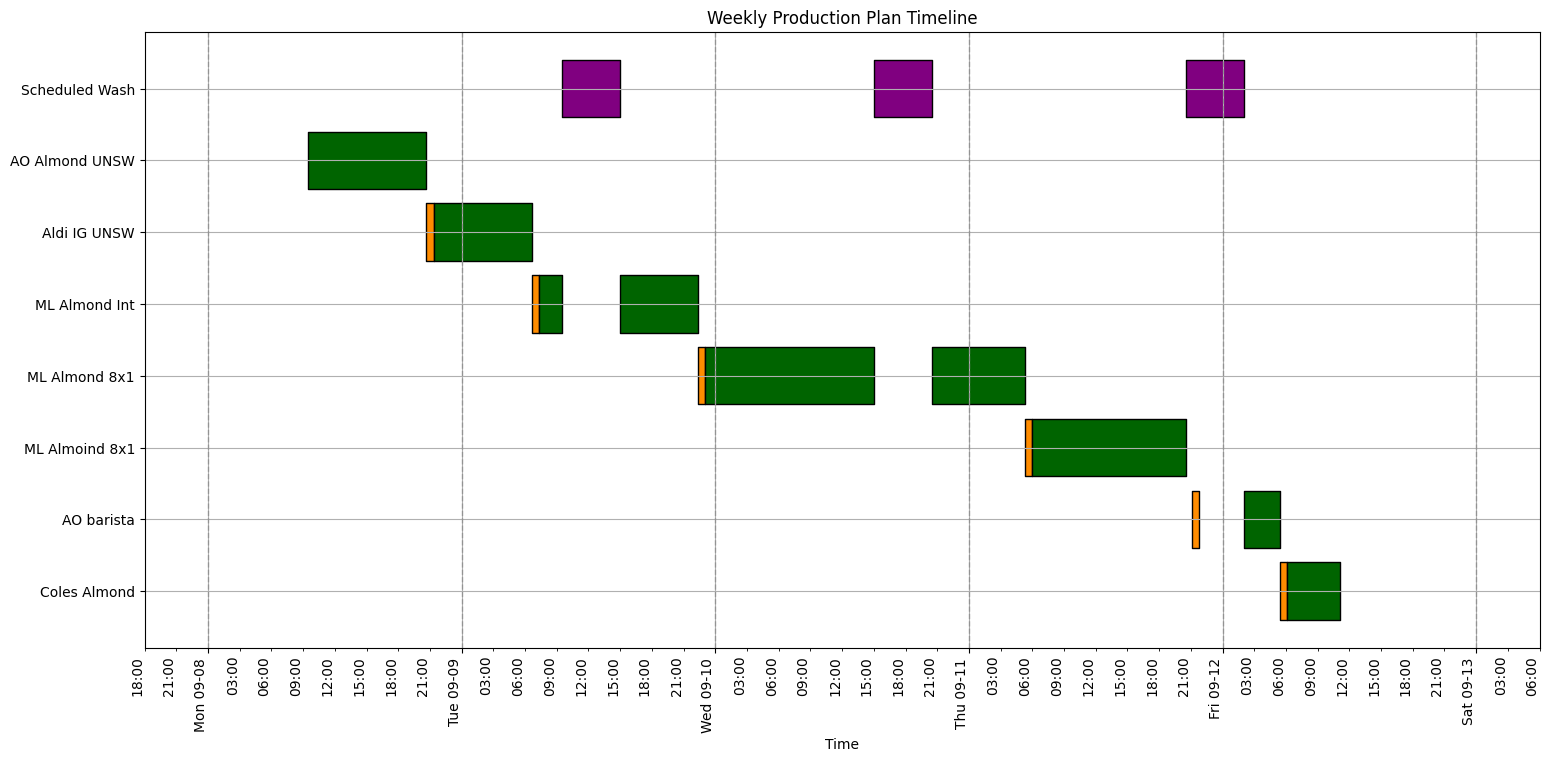

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from tkinter import Tk, filedialog
import os
import sys

def generate_timeline(df):
    """
    Processes the production plan data and generates a timeline.

    Args:
        df (pd.DataFrame): The DataFrame containing the production plan data.

    Returns:
        matplotlib.figure.Figure: The generated timeline figure.
    """
    # Define colors for each task
    colors = {
        'processing': 'darkgreen',
        'wash': 'purple',
        'changeover': 'darkorange'
    }

    tasks = []

    # Get the start date
    try:
        start_time_of_week = pd.to_datetime(df.loc[0, 'Date from'])
    except Exception as e:
        print(f"Error parsing 'Date from' column: {e}. Please ensure it's in a valid date/time format.")
        return None

    current_time = start_time_of_week

    # Read wash duration and gap
    try:
        wash_duration_mins = int(df.loc[0, 'Duration'])
        wash_gap_mins = int(df.loc[0, 'Gap'])
        wash_duration = timedelta(minutes=wash_duration_mins)
        gap_duration = timedelta(minutes=wash_gap_mins)
    except Exception as e:
        print(f"Warning: Error reading wash duration/gap: {e}. Wash cycle will not be scheduled.")
        wash_duration = timedelta(0)
        gap_duration = timedelta(0)

    last_wash_end_time = start_time_of_week

    # Iterate through products
    for i, row in df.iterrows():
        product_name = row['product name']
        quantity_liters = row['quantity liters']
        process_speed = row['process speed per hour']
        line_efficiency = row['line efficiency']
        change_over_mins = row['Change Over']

        # Changeover
        if i > 0:
            change_over_duration = timedelta(minutes=change_over_mins)
            changeover_end_time = current_time + change_over_duration

            # Washes in changeover
            next_wash_start_time = last_wash_end_time + gap_duration
            scheduled_washes_in_changeover = []
            while next_wash_start_time < changeover_end_time:
                wash_end_time = next_wash_start_time + wash_duration
                scheduled_washes_in_changeover.append({'start': next_wash_start_time, 'end': wash_end_time})
                last_wash_end_time = wash_end_time
                next_wash_start_time = last_wash_end_time + gap_duration

            overlaps = any(
                max(current_time, wash['start']) < min(changeover_end_time, wash['end'])
                for wash in scheduled_washes_in_changeover
            )

            if overlaps:
                overlapping_washes = [
                    wash for wash in scheduled_washes_in_changeover
                    if max(current_time, wash['start']) < min(changeover_end_time, wash['end'])
                ]
                if overlapping_washes:
                    current_time = max(wash['end'] for wash in overlapping_washes)
                for wash in scheduled_washes_in_changeover:
                    tasks.append({
                        'start': wash['start'],
                        'end': wash['end'],
                        'duration_hours': (wash['end'] - wash['start']).total_seconds() / 3600,
                        'task': 'wash',
                        'product': 'Scheduled Wash',
                        'order': -1
                    })
            else:
                tasks.append({
                    'start': current_time,
                    'end': changeover_end_time,
                    'duration_hours': change_over_mins / 60,
                    'task': 'changeover',
                    'product': product_name,
                    'order': i
                })
                current_time = changeover_end_time

        # Processing time
        effective_speed = process_speed * line_efficiency
        total_processing_hours = quantity_liters / effective_speed
        processing_end_time = current_time + timedelta(hours=total_processing_hours)

        # Washes in processing
        next_wash_start_time = last_wash_end_time + gap_duration
        while next_wash_start_time < processing_end_time:
            wash_end_time = next_wash_start_time + wash_duration
            tasks.append({
                'start': next_wash_start_time,
                'end': wash_end_time,
                'duration_hours': wash_duration.total_seconds() / 3600,
                'task': 'wash',
                'product': 'Scheduled Wash',
                'order': -1
            })
            last_wash_end_time = wash_end_time
            next_wash_start_time = last_wash_end_time + gap_duration

        # Processing segments
        segment_start_time = current_time
        scheduled_wash_intervals = [
            (wash['start'], wash['end'])
            for wash in tasks if wash['task'] == 'wash' and max(segment_start_time, wash['start']) < min(processing_end_time, wash['end'])
        ]
        scheduled_wash_intervals.sort()

        for wash_start, wash_end in scheduled_wash_intervals:
            if segment_start_time < wash_start:
                tasks.append({
                    'start': segment_start_time,
                    'end': wash_start,
                    'duration_hours': (wash_start - segment_start_time).total_seconds() / 3600,
                    'task': 'processing',
                    'product': product_name,
                    'order': i
                })
            segment_start_time = max(segment_start_time, wash_end)

        if segment_start_time < processing_end_time:
            tasks.append({
                'start': segment_start_time,
                'end': processing_end_time,
                'duration_hours': (processing_end_time - segment_start_time).total_seconds() / 3600,
                'task': 'processing',
                'product': product_name,
                'order': i
            })

        current_time = processing_end_time

    # Plot
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.set_facecolor('white')

    y_pos = 0
    product_y_positions = {}
    product_order = []

    tasks_df = pd.DataFrame(tasks).sort_values(by='order')
    unique_products_ordered = ['Scheduled Wash'] + [p for p in tasks_df['product'].unique() if p != 'Scheduled Wash']

    for product_name in unique_products_ordered:
        group = tasks_df[tasks_df['product'] == product_name].sort_values(by='start')
        product_y_positions[product_name] = y_pos
        product_order.append(product_name)
        for _, task in group.iterrows():
            ax.broken_barh(
                [(mdates.date2num(task['start']), (task['end'] - task['start']).total_seconds() / (24*3600))],
                (y_pos - 0.4, 0.8),
                facecolors=colors[task['task']], edgecolor='black'
            )
        y_pos += 1

    ax.set_yticks(list(product_y_positions.values()))
    ax.set_yticklabels(product_order)
    ax.set_xlabel("Time")
    ax.set_title("Weekly Production Plan Timeline")
    ax.grid(True)
    ax.invert_yaxis()

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    if not tasks_df.empty:
        first_date = tasks_df['start'].min().floor('D')
        last_date = tasks_df['end'].max().ceil('D')
        delta_days = (last_date - first_date).days + 1
        for day in range(delta_days):
            day_start = first_date + timedelta(days=day)
            ax.axvline(day_start, color='gray', linestyle='--', linewidth=1, alpha=0.6)

    plt.xticks(rotation=90, ha='right', va='top')
    plt.setp(ax.get_xminorticklabels(), rotation=90, ha='right', va='top')

    handles = [plt.Rectangle((0, 0), 1, 1, fc=colors[t]) for t in colors]
    ax.legend(handles, colors.keys(), loc='upper right')

    plt.tight_layout()
    return fig

def main():
    # Open file picker
    Tk().withdraw()
    file_path = filedialog.askopenfilename(
        title="Select Production Plan File",
        filetypes=[("Excel files", "*.xlsx *.xls"), ("CSV files", "*.csv")]
    )

    if not file_path:
        print("No file selected. Exiting.")
        sys.exit()

    print(f"File selected: {file_path}")

    try:
        if file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        else:
            df = pd.read_excel(file_path)

        print("\nData preview:")
        print(df.head())

        required_columns = ['product name', 'quantity liters', 'process speed per hour',
                            'line efficiency', 'Change Over', 'Date from', 'Duration', 'Gap']
        if not all(col in df.columns for col in required_columns):
            missing = [c for c in required_columns if c not in df.columns]
            print(f"\nError: Missing required columns: {', '.join(missing)}")
            sys.exit()

        fig = generate_timeline(df)

        if fig:
            output_filename = "production_timeline.png"
            fig.savefig(output_filename, bbox_inches="tight")
            print(f"\nTimeline generated successfully. Saved as '{output_filename}'")
            os.startfile(output_filename)  # Auto-open (Windows only)

    except Exception as e:
        print(f"\nAn error occurred: {e}")

if __name__ == "__main__":
    main()
